In [1]:
import os
import json
import random
from time import clock
from PIL import Image
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split
from scipy.misc import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

## Loading Tiny Imagenet

In [2]:
data = {}
t1 = clock()
for folder in os.listdir("tiny-imagenet-200/train"):
    if folder != ".DS_Store":
        for subfolder in os.listdir("tiny-imagenet-200/train/"+folder):
            if subfolder == "images":
                for file in os.listdir("tiny-imagenet-200/train/"+folder+"/"+subfolder):
                    img = Image.open("tiny-imagenet-200/train/"+folder+"/"+subfolder+"/"+file, "r")
                    if np.array(img).shape == (64, 64, 3):  # don't add grayscale images
                        if file[:9] in data.keys():
                            data[file[:9]].append(np.array(img.resize((256, 256))))
                        else:
                            data[file[:9]] = [np.array(img.resize((256, 256)))]
t2 = clock()
print("Total time elapsed:", t2-t1)

Total time elapsed: 181.653852


In [3]:
ids = list(data.keys())

In [4]:
id_dict = {}
with open("semantic_map.txt") as labels:
    for line in labels:
        if line != "\n":
            key = line[:9]
            tags = line[10:-1].split(", ")
            if key in ids:
                id_dict[key] = tags

A sample pixel array for image class n02795169 ['barrel', 'cask'] :
Image is of size: (256, 256, 3)


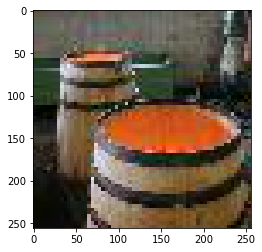

In [5]:
for im, arrs in data.items():
    print("A sample pixel array for image class", im, id_dict[im], ":")
    print("Image is of size:", arrs[1].shape)
    plt.imshow(arrs[1])
    break
plt.show()

In [6]:
def one_hot(classes, index):
    vec = np.zeros(classes)
    vec[index] = 1
    return vec

In [8]:
t1 = clock()
x = []
y = []
for key, vals in data.items():
    x += vals
    for i in range(len(vals)):
        y.append(one_hot(200, ids.index(key)))
t2 = clock()
print("Time elapsed:", t2-t1)

Time elapsed: 0.7293540000000007


In [9]:
len(y) == len(x)

True

In [10]:
# shuffle data
combined = list(zip(x, y))
random.shuffle(combined)

x[:], y[:] = zip(*combined)

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

## Alexnet

### Define Layer Functions

In [38]:
def conv(x, filter_size, num_filters, stride, name, padding="SAME", groups=1):
    channels = int(x.shape[-1])
    convolve = lambda a, b: tf.nn.conv2d(a, b, strides=[1, stride, stride, 1], padding=padding)

    with tf.variable_scope(name) as scope:
        w = tf.get_variable("w", shape=[filter_size, filter_size, int(channels/groups), num_filters])
        b = tf.get_variable("b", shape=[num_filters])

        if groups == 1:
            conv = convolve(x, w)   
        else:
            input_groups = tf.split(axis=3, num_or_size_splits=groups, value=x)
            weights_groups = tf.split(axis=3, num_or_size_splits=groups, value=w)
            output_groups = [convolve(i, k) for i, k in zip(input_groups, weights_groups)]
            
            conv = tf.concat(axis=3, values=output_groups)

        output = tf.reshape(tf.nn.bias_add(conv, b), conv.shape.as_list())
        relu = tf.nn.relu(output)

        return relu

In [39]:
def max_pool(x, filter_size, stride, name, padding='SAME'):
        return tf.nn.max_pool(x, ksize=[1, filter_size, filter_size, 1], 
                              strides = [1, stride, stride, 1], padding=padding, name=name)

In [40]:
def lrn(x, name, radius=5, alpha=0.0001, beta=0.75, bias=2.0):
        return tf.nn.local_response_normalization(x, depth_radius=radius, alpha=alpha, beta=beta, bias=bias, name=name)

In [41]:
def fc(x, dim_in, dim_out, name, drop_ratio=0, relu=True):
    with tf.variable_scope(name) as scope:
        w = tf.get_variable("w", shape=[dim_in, dim_out], trainable=True)
        b = tf.get_variable("b", [dim_out], trainable=True)

        output = tf.nn.xw_plus_b(x, w, b, name=scope.name)

        if relu == True:
            relu = tf.nn.relu(output)       
            if drop_ratio == 0:
                return relu
            else:
                return tf.nn.dropout(relu, drop_ratio)

        else:
            if drop_ratio == 0:
                return output
            else:
                return tf.nn.dropout(output, drop_ratio)

### Build Model

In [80]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=[1, 256, 256, 3], name="X")  
Y = tf.placeholder(tf.float32,shape=(None, 200), name="Y")

conv1 = conv(X,11,96,4,name="conv1", padding="VALID")
pool1 = max_pool(conv1, filter_size=3, stride=2, name="pool1", padding="VALID")
lrn1 = lrn(pool1, name="lrn1")

conv2 = conv(lrn1,5,256,1,name="conv2", groups=2)
pool2 = max_pool(conv2, filter_size=3, stride=2, name="pool2", padding="VALID")
lrn2 = lrn(pool2, name="norm2")

conv3 = conv(lrn2, 3, 384, 1, name="conv3")

conv4 = conv(conv3, 3, 384, 1, name="conv4", groups=2)

conv5 = conv(conv4, 3, 256, 1, name="conv5", groups=2)
pool5 = max_pool(conv5, filter_size=3, stride=2, name="pool5", padding="VALID")

flattened = tf.reshape(pool5, [-1,6*6*256])
fc6 = fc(flattened, dim_in=6*6*256, dim_out=4096, name="fc6", drop_ratio=0.5, relu=True)

fc7 = fc(fc6, dim_in=4096, dim_out=4096, name="fc7", drop_ratio=0.5, relu=True)

fc8 = fc(fc7, dim_in=4096, dim_out=200, name="fc8", drop_ratio=0, relu=False)

### Run Model

In [43]:
batch_size = 1
n_dim = [1, 256, 256, 3]
n_classes = 200
alpha = 0.001
epochs = 1

In [81]:
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=fc8))
optimizer = tf.train.AdamOptimizer(alpha).minimize(cost_function)
correct_prediction = tf.equal(tf.argmax(fc8,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# saver = tf.train.Saver()

init = tf.global_variables_initializer()

In [91]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
   
        offset = (epoch * batch_size) % (len(y_test) - batch_size)
        batch_x = x_test[offset:offset + batch_size]
        batch_y = y_test[offset:offset + batch_size]
        
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:batch_x,Y:batch_y})
        
        if epoch % 100 == 0:
            print("Epoch:", epoch, "Cost:", cost)
        cost_history = np.append(cost_history, cost)

Epoch: 0 Cost: 5.15249
